# Assignment 2: Text Classification
Marko Praček, Vid Koncilja <div>
Januar 2025

### Imports:

In [12]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import seaborn as sns
import optuna
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer



nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

### Functions used:

In [50]:
def plot_learning_curve(classifier, X_train, y_train, X_val, y_val, X_test, y_test,name):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)

    val_accuracy = accuracy_score(y_val, pipeline.predict(X_val))
    test_accuracy = accuracy_score(y_test, pipeline.predict(X_test))
    print(f"Validation Accuracy: {val_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

  
    train_sizes = np.linspace(0.1, 1.0, 10)
    test_accuracies = []
    val_accuracies = []


    for train_size in train_sizes:
        current_train_data = X_train.sample(frac=train_size, random_state=42)
        y_current_train = y_train.loc[current_train_data.index]
        
        pipeline.fit(current_train_data, y_current_train)

        test_acc = accuracy_score(y_test, pipeline.predict(X_test))
        test_accuracies.append(test_acc)

        val_acc = accuracy_score(y_val, pipeline.predict(X_val))
        val_accuracies.append(val_acc)

    plt.plot(train_sizes, test_accuracies, label="Test Accuracy", color="blue")
    plt.plot(train_sizes, val_accuracies, label="Validation Accuracy", color="green")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve for {classifier.__class__.__name__}\nfor different training sizes ({name})")
    plt.legend()
    plt.grid()

    results = {
        'pipeline': pipeline,
        'train_sizes': train_sizes,
        'test_accuracies': test_accuracies,
        'val_accuracies': val_accuracies
    }
    
    return pipeline, results


In [61]:
def plot_confusion_matrix(pipeline, X_val, y_val, label_mapping, model_name="Classifier", ax=None):
    if ax is None:
        ax = plt.gca()
    y_val_pred = pipeline.predict(X_val)
    cm = confusion_matrix(y_val, y_val_pred)
    class_names = [f"{key} - {value}" for key, value in label_mapping.items()]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax)
    ax.set_title("Confusion Matrix for " + model_name)

def plot_feature_importance(pipeline, ax=None):
    if ax is None:
        ax = plt.gca()
    vectorizer = pipeline.named_steps['tfidf']
    classifier = pipeline.named_steps['classifier']
    feature_names = vectorizer.get_feature_names_out()
    feature_importance = classifier.feature_importances_
    important_words = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    important_words = important_words.sort_values(by='Importance', ascending=False)
    sns.barplot(data=important_words.head(10), x='Importance', y='Feature', color='blue', ax=ax)
    ax.set_title("Top 10 Most Important Features")
    ax.set_xlabel("Feature Importance")
    ax.set_ylabel("Feature")

def plot_cumulative_feature_importance(pipeline, ax=None):
    if ax is None:
        ax = plt.gca()
    vectorizer = pipeline.named_steps['tfidf']
    classifier = pipeline.named_steps['classifier']
    feature_names = vectorizer.get_feature_names_out()
    feature_importance = classifier.feature_importances_
    important_words = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    important_words = important_words.sort_values(by='Importance', ascending=False)
    cumulative_importance = important_words['Importance'].cumsum()
    ax.plot(range(len(cumulative_importance)), cumulative_importance, marker='o', color='purple')
    ax.set_title("Cumulative Feature Importance")
    ax.set_xlabel("Number of Features")
    ax.set_ylabel("Cumulative Importance")
    ax.grid()

def plot_tree_depth_distribution(pipeline, model_name="Classifier", ax=None):
    if ax is None:
        ax = plt.gca()
    rf_model = pipeline.named_steps['classifier']
    tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
    sns.histplot(tree_depths, bins=10, kde=True, color='green', ax=ax)
    ax.set_title("Distribution of Tree Depths")
    ax.set_xlabel("Tree Depth")
    ax.set_ylabel("Frequency")

def plot_all(pipeline, X_val, y_val, label_mapping, model_name="Classifier", data_name="Data"):
    if model_name == "DecisionTreeClassifier":
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        plot_confusion_matrix(pipeline, X_val, y_val, label_mapping, model_name, ax=axes[0])
        plot_feature_importance(pipeline, ax=axes[1])
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 6))
        plot_confusion_matrix(pipeline, X_val, y_val, label_mapping, model_name, ax=axes[0, 0],)
        plot_feature_importance(pipeline, ax=axes[0, 1])
        plot_tree_depth_distribution(pipeline, model_name, ax=axes[1, 0])
        plot_cumulative_feature_importance(pipeline, ax=axes[1, 1])
    fig.suptitle(f"{model_name} ({data_name})", fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()  
    plt.show()

In [7]:
def plot_learning_curve_for_param(pipeline,param_name, param_values, X_train, y_train, X_val, y_val,y_test,X_test):
    test_accuracies = []
    val_accuracies = []
    
    for param_value in param_values:
        pipeline_copy = clone(pipeline)
        
        pipeline_copy.set_params(**{f'classifier__{param_name}': param_value})
        
        pipeline_copy.fit(X_train, y_train)
        
        test_acc = accuracy_score(y_test, pipeline_copy.predict(X_test))
        val_acc = accuracy_score(y_val, pipeline_copy.predict(X_val))

        test_accuracies.append(test_acc)
        val_accuracies.append(val_acc)

    plt.plot(param_values, test_accuracies, label="Test Accuracy", color="blue")
    plt.plot(param_values, val_accuracies, label="Validation Accuracy", color="green")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f"Effect of {param_name} on Accuracy", fontsize=10)  
    plt.legend()
    plt.grid(True)

In [80]:
def plt_parameters(classifier_name, pipeline, param_name, param_values, X_train, y_train, X_val, y_val, y_test, X_test,data_name):
   
    num_params = len(param_name)
    num_rows = (num_params // 3) + (num_params % 3 > 0)  
    plt.figure(figsize=(12, 6 * num_rows)) 
    idx = 1
    
    for param_value in param_values:
        plt.subplot(num_rows, 3, idx)
        plot_learning_curve_for_param(pipeline, param_name[idx - 1], param_value, X_train, y_train, X_val, y_val, y_test, X_test)
        idx += 1
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.93)  
    fig = plt.gcf()
    fig.suptitle(f'{classifier_name}-Influence of different hyperparameters ({data_name})', fontsize=25, y=1.02)
    
    plt.tight_layout()
    plt.show()


In [15]:
def preprocess_text(input_text,lemmatizer=WordNetLemmatizer(),stop_words=set(stopwords.words('english'))):
    processed_words = [
        lemmatizer.lemmatize(word)
        for word in input_text.split()
        if word not in stop_words
    ]
    
    return ' '.join(processed_words)


In [67]:
def objective(pipeline,trial, X_train, y_train):
  
    max_depth = trial.suggest_categorical('classifier__max_depth', [5, 10, 15, None])
    min_samples_split = trial.suggest_int('classifier__min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('classifier__min_samples_leaf', 1, 9, step=2)
    criterion = trial.suggest_categorical('classifier__criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical('classifier__max_features', ['sqrt', 'log2', None])
    
    pipeline.set_params(
        classifier__max_depth=max_depth,
        classifier__min_samples_split=min_samples_split,
        classifier__min_samples_leaf=min_samples_leaf,
        classifier__criterion=criterion,
        classifier__max_features=max_features
    )
    score
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy')
    return score.mean()


In [89]:

def objective_Forst(pipeline,trial, X_train, y_train):

    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)


    pipeline.set_params(
        classifier__n_estimators=n_estimators,
        classifier__max_depth=max_depth,
        classifier__min_samples_split=min_samples_split,
        classifier__min_samples_leaf=min_samples_leaf,
        classifier__criterion=criterion,
        classifier__bootstrap=bootstrap,
        classifier__max_leaf_nodes=max_leaf_nodes
    )

    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy')
    return score.mean()


## Task 1 - Data preparation and exploration


### Load the data and extract some basic information
- Are there missing values?
- what is the distribution of the class variable?
- How long are the texts?



MISSING VALUES
 text     0
label    0
dtype: int64

CLASS DISTRIBUTION
 label
1    1703
0    1443
3     671
4     584
2     401
5     198
Name: count, dtype: int64


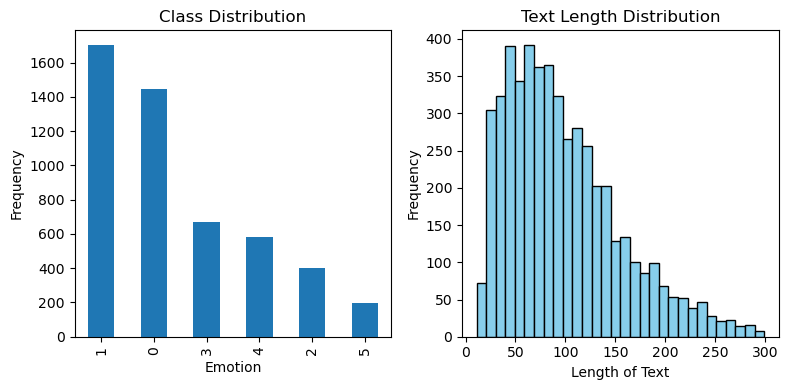

In [9]:
data = []
with open('dataset.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

#check if any data is missing
missing_values = df.isnull().sum()
print("\nMISSING VALUES\n",missing_values)



class_distribution = df['label'].value_counts()

print("\nCLASS DISTRIBUTION\n",class_distribution)

df['text_length'] = df['text'].apply(len)
text_length_stats = df['text_length'].describe()
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
class_distribution.plot(kind='bar', title='Class Distribution', xlabel='Emotion', ylabel='Frequency')
plt.subplot(1, 2, 2)
plt.hist(df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Data Processing

### Data Split
- Train set: 80%
- Validation set: 15%
- Test set: 5%

### Clean Data
- **Stop Words Removal**  
  We will remove common stop words that do not contribute meaningful information to the model.
  
- **Lemmatization**  
  Lemmatization will be applied to reduce words to their base form, e.g., "running" -> "run".


In [42]:
df['text'] = df['text'].fillna("") 


train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_data['label'], random_state=42)

train_data_cleaned = train_data.copy()
val_data_cleaned = val_data.copy()
test_data_cleaned = test_data.copy()

train_data_cleaned['text'] = train_data_cleaned['text'].apply(preprocess_text)
val_data_cleaned['text'] = val_data_cleaned['text'].apply(preprocess_text)
test_data_cleaned['text'] = test_data_cleaned['text'].apply(preprocess_text)

datasets = {
    "clean": {
        "X_train": train_data_cleaned['text'],
        "X_val": val_data_cleaned['text'],
        "X_test": test_data_cleaned['text'],
        "y_train": train_data_cleaned['label'],
        "y_val": val_data_cleaned['label'],
        "y_test": test_data_cleaned['label']
    },
    "unclean": {
        "X_train": train_data['text'],
        "X_val": val_data['text'],
        "X_test": test_data['text'],
        "y_train": train_data['label'],
        "y_val": val_data['label'],
        "y_test": test_data['label']
    }
}


## Task 2 - Basic machine learning

### Decision Tree Classifier
-  Make a default DTC
-  Analize 
-  Change hyperparameters 
First, we examine how well the Decision Tree Classifier learns with its default hyperparameters. We are also interested in how the size of the training data affects the results.


ORIGINAL DATA
Validation Accuracy: 0.79
Test Accuracy: 0.81

 CLEAN DATA
Validation Accuracy: 0.84
Test Accuracy: 0.83


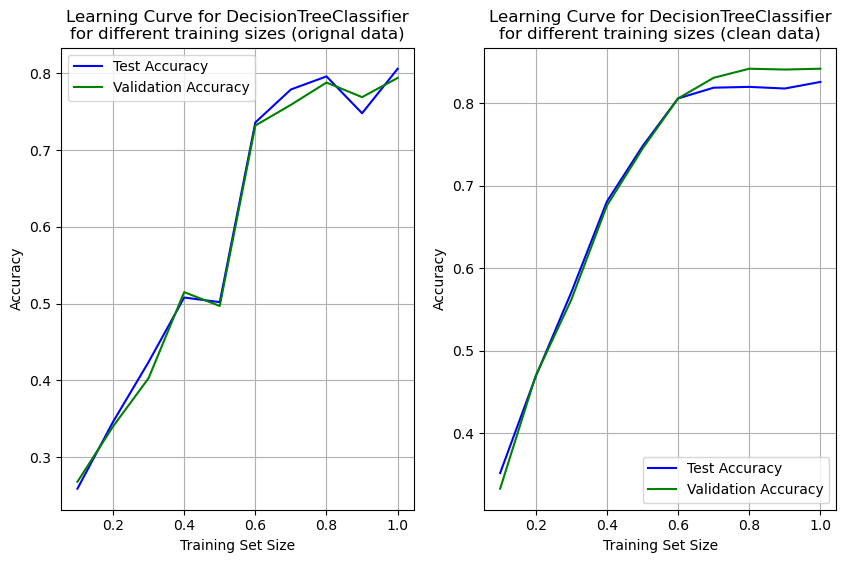

In [52]:

classifier = DecisionTreeClassifier(random_state=42)
name_clean = "clean data"
name_unclean = "orignal data"
print("\nORIGINAL DATA")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
pipeline, results_unclean = plot_learning_curve(
    classifier, 
    datasets["unclean"]["X_train"], 
    datasets["unclean"]["y_train"], 
    datasets["unclean"]["X_val"], 
    datasets["unclean"]["y_val"], 
    datasets["unclean"]["X_test"], 
    datasets["unclean"]["y_test"],
    name_unclean
)
print("\n CLEAN DATA")
plt.subplot(1, 2, 2)
pipeline, results_clean = plot_learning_curve(
    classifier, 
    datasets["clean"]["X_train"], 
    datasets["clean"]["y_train"], 
    datasets["clean"]["X_val"], 
    datasets["clean"]["y_val"], 
    datasets["clean"]["X_test"], 
    datasets["clean"]["y_test"],
    name_clean
)



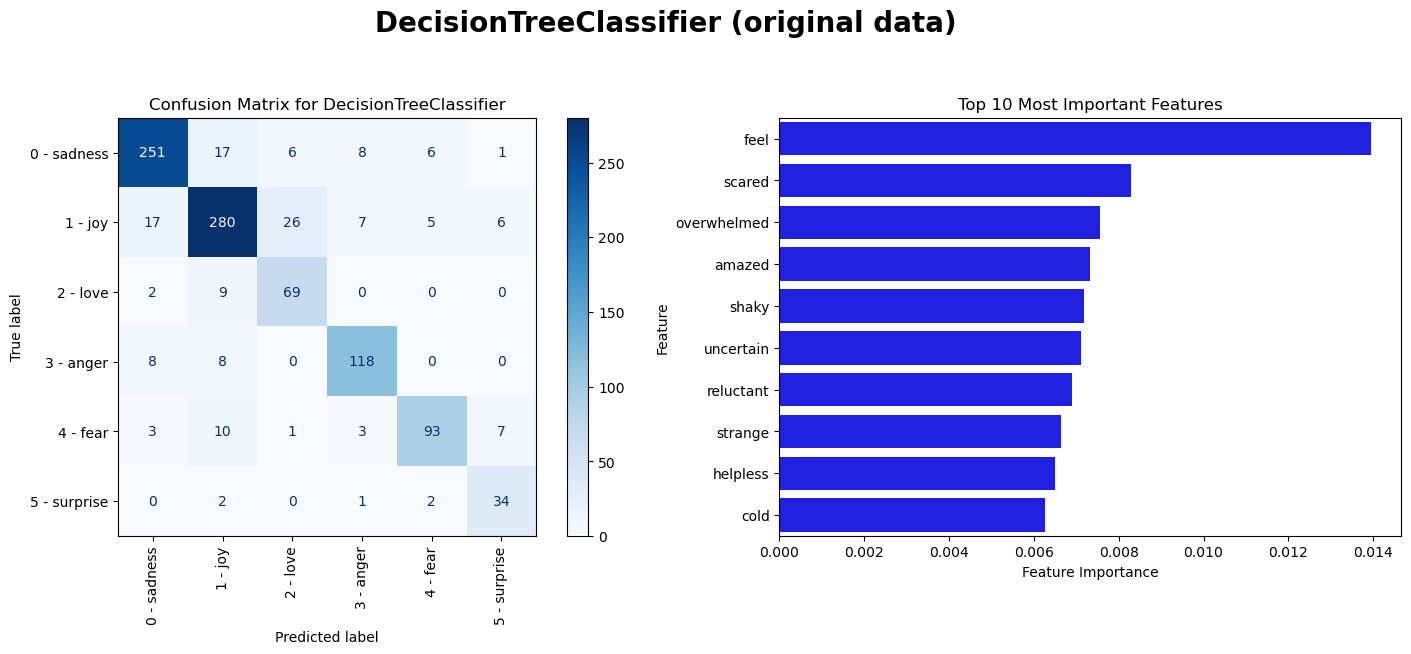

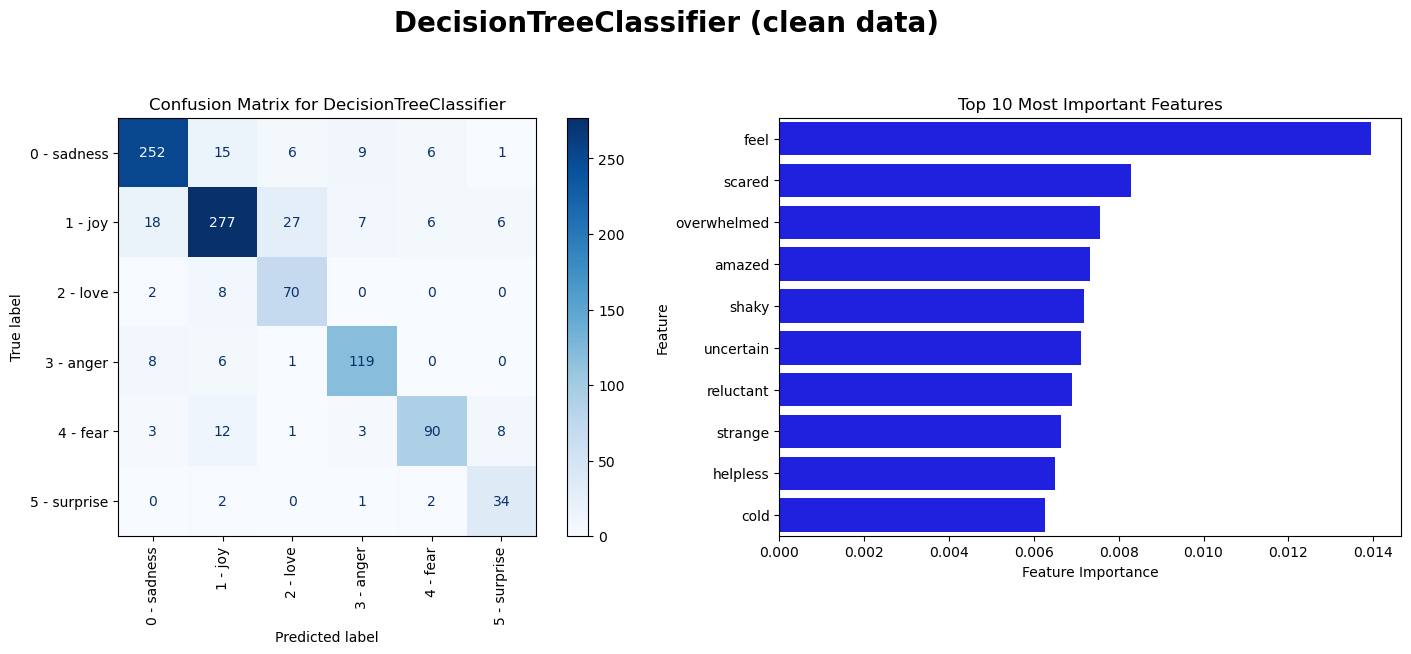

In [63]:
plot_all(pipeline, datasets["unclean"]["X_val"], datasets["unclean"]["y_val"], label_mapping, model_name="DecisionTreeClassifier",data_name="original data")
plot_all(pipeline, datasets["clean"]["X_val"], datasets["clean"]["y_val"], label_mapping, model_name="DecisionTreeClassifier",data_name="clean data")

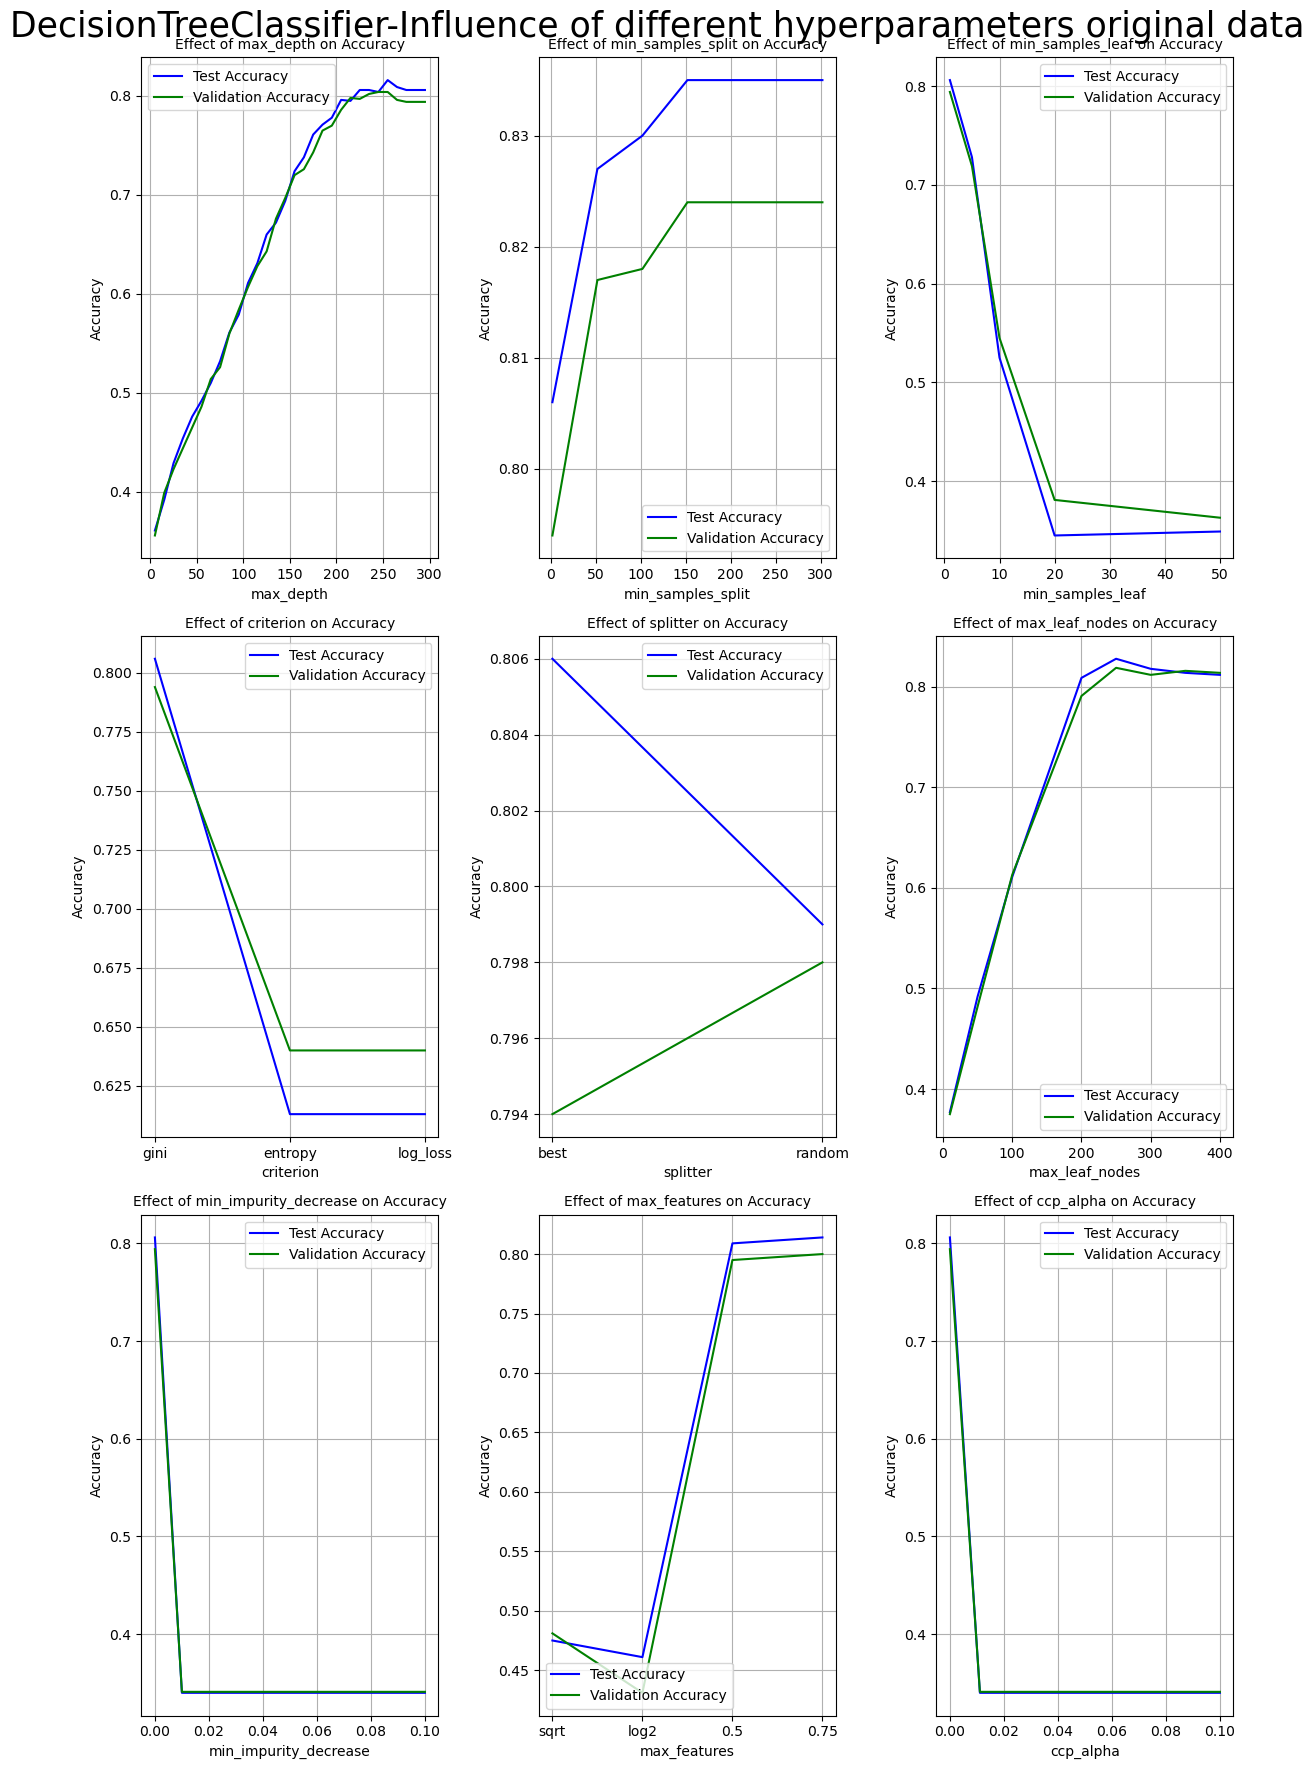

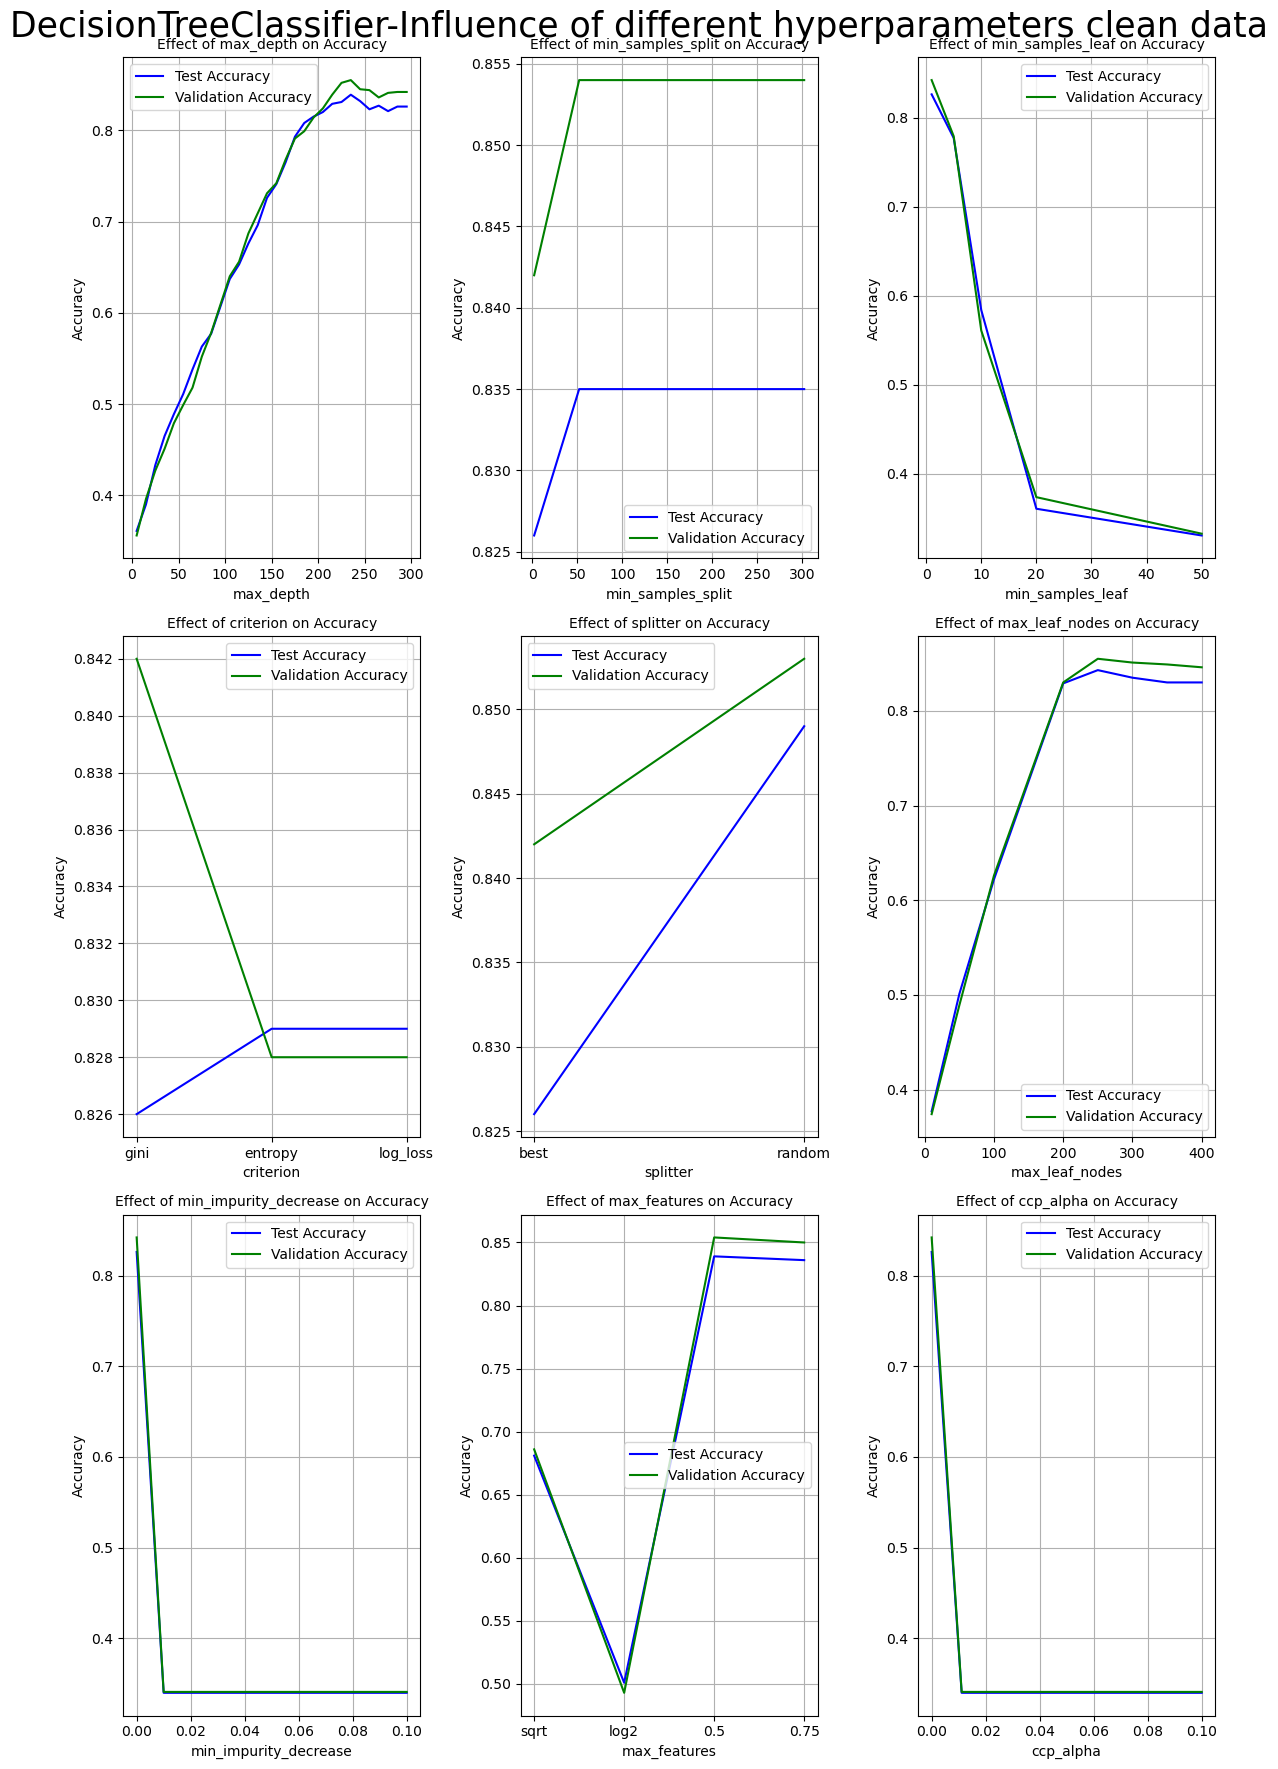

In [65]:
para_names = ["max_depth", "min_samples_split", "min_samples_leaf", "criterion", "splitter", "max_leaf_nodes", "min_impurity_decrease", "max_features", "ccp_alpha"]
para_values = [np.arange(5, 300, 10), np.arange(2, 350, 50), [1, 5, 10, 20, 50], ['gini', 'entropy', 'log_loss'], ['best', 'random'], [10, 50, 100, 200, 250, 300, 350, 400], [0.0, 0.01, 0.05, 0.1], ['sqrt', 'log2', 0.5, 0.75], np.linspace(0.0, 0.1, 10)]

plt_parameters("DecisionTreeClassifier", pipeline, para_names, para_values, datasets["unclean"]["X_train"], datasets["unclean"]["y_train"], datasets["unclean"]["X_val"], datasets["unclean"]["y_val"], datasets["unclean"]["y_test"], datasets["unclean"]["X_test"],data_name="original data")
plt_parameters("DecisionTreeClassifier", pipeline, para_names, para_values, datasets["clean"]["X_train"], datasets["clean"]["y_train"], datasets["clean"]["X_val"], datasets["clean"]["y_val"], datasets["clean"]["y_test"], datasets["clean"]["X_test"],data_name="clean data")

### Cross validation (TO DO)

## Get the best results with the original data

In [75]:

def objective(trial, X_train, y_train):
    max_depth = trial.suggest_categorical('classifier__max_depth', [5, 10, 15, None])
    min_samples_split = trial.suggest_int('classifier__min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('classifier__min_samples_leaf', 1, 9, step=2)
    criterion = trial.suggest_categorical('classifier__criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical('classifier__max_features', ['sqrt', 'log2', None])
    
   
    pipeline.set_params(
        classifier__max_depth=max_depth,
        classifier__min_samples_split=min_samples_split,
        classifier__min_samples_leaf=min_samples_leaf,
        classifier__criterion=criterion,
        classifier__max_features=max_features
    )
    
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy')
    return score.mean()

study_o = optuna.create_study(direction='maximize')
study_o.optimize(lambda trial: objective(trial, datasets["unclean"]["X_train"], datasets["unclean"]["y_train"]), n_trials=100)
best_trial_o = study_o.best_trial
print(f"Best Parameters (Original Data): {best_trial_o.params}")
print(f"Best Score: {best_trial_o.value}")

best_model_o = pipeline.set_params(**best_trial_o.params)
best_model_o.fit(datasets["unclean"]["X_train"], datasets["unclean"]["y_train"])
test_accuracy_o = accuracy_score(datasets["unclean"]["y_test"], best_model_o.predict(datasets["unclean"]["X_test"]))
print(f"\nTest Accuracy with the Best Model (Original Data): {test_accuracy_o:.2f}")




[I 2025-01-10 17:32:50,422] A new study created in memory with name: no-name-cc7619b8-69a4-480d-a1dc-953c722d2962
c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [1, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 9].
  warnings.warn(
[I 2025-01-10 17:32:59,261] Trial 0 finished with value: 0.5296666666666667 and parameters: {'classifier__max_depth': 200, 'classifier__min_samples_split': 34, 'classifier__min_samples_leaf': 7, 'classifier__criterion': 'gini', 'classifier__max_features': None}. Best is trial 0 with value: 0.5296666666666667.
c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [1, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 9].
  warnings.warn(
[I 2025-01-10 17:33:04,091] Trial 1 finished with value: 0.5233333333333332 and parameters: {'cla

Best Parameters (Original Data): {'classifier__max_depth': 250, 'classifier__min_samples_split': 38, 'classifier__min_samples_leaf': 1, 'classifier__criterion': 'gini', 'classifier__max_features': None}
Best Score: 0.7140000000000001

Test Accuracy with the Best Model (Original Data): 0.83


## Get the best results with the clean data

In [76]:
study_c = optuna.create_study(direction='maximize')
study_c.optimize(lambda trial: objective(trial, datasets["clean"]["X_train"], datasets["clean"]["y_train"]), n_trials=100)
best_trial_c = study_c.best_trial
print(f"Best Parameters (Cleaned Data): {best_trial_c.params}")
print(f"Best Score: {best_trial_c.value}")

best_model_c = pipeline.set_params(**best_trial_c.params)
best_model_c.fit(datasets["clean"]["X_train"], datasets["clean"]["y_train"])
test_accuracy_c = accuracy_score(datasets["clean"]["y_test"], best_model_c.predict(datasets["clean"]["X_test"]))
print(f"\nTest Accuracy with the Best Model (Cleaned Data): {test_accuracy_c:.2f}")


[I 2025-01-10 17:37:55,475] A new study created in memory with name: no-name-707a6fdf-7690-4112-9e17-524a71232432
c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [1, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 9].
  warnings.warn(
[I 2025-01-10 17:37:56,258] Trial 0 finished with value: 0.8503333333333334 and parameters: {'classifier__max_depth': 250, 'classifier__min_samples_split': 36, 'classifier__min_samples_leaf': 1, 'classifier__criterion': 'gini', 'classifier__max_features': 0.5}. Best is trial 0 with value: 0.8503333333333334.
c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [1, 10] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 9].
  warnings.warn(
[I 2025-01-10 17:37:57,370] Trial 1 finished with value: 0.834 and parameters: {'classifier__max_d

Best Parameters (Cleaned Data): {'classifier__max_depth': None, 'classifier__min_samples_split': 38, 'classifier__min_samples_leaf': 1, 'classifier__criterion': 'gini', 'classifier__max_features': 0.5}
Best Score: 0.8516666666666668

Test Accuracy with the Best Model (Cleaned Data): 0.84


### Random Forest Classifier
-  Make a default RFC
-  Analize 
-  Change hyperparameters 
First, we examine how well the Decision Tree Classifier learns with its default hyperparameters. We are also interested in how the size of the training data affects the results.

In [93]:

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(random_state=42))
])



ORIGINAL DATA
Validation Accuracy: 0.68
Test Accuracy: 0.67

 CLEAN DATA
Validation Accuracy: 0.80
Test Accuracy: 0.81


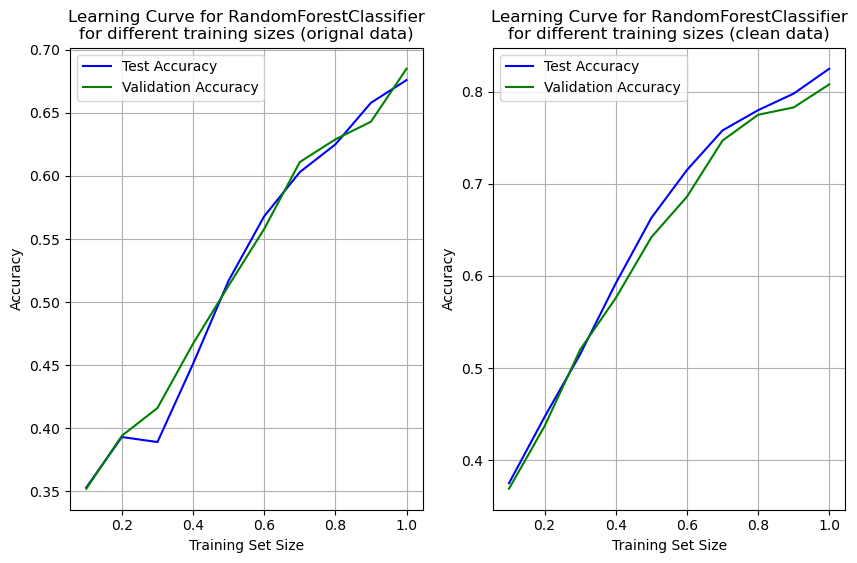

In [78]:
classifier = RandomForestClassifier(random_state=42)
name_clean = "clean data"
name_unclean = "orignal data"
print("\nORIGINAL DATA")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
pipeline, results_unclean = plot_learning_curve(
    classifier, 
    datasets["unclean"]["X_train"], 
    datasets["unclean"]["y_train"], 
    datasets["unclean"]["X_val"], 
    datasets["unclean"]["y_val"], 
    datasets["unclean"]["X_test"], 
    datasets["unclean"]["y_test"],
    name_unclean
)
print("\n CLEAN DATA")
plt.subplot(1, 2, 2)
pipeline, results_clean = plot_learning_curve(
    classifier, 
    datasets["clean"]["X_train"], 
    datasets["clean"]["y_train"], 
    datasets["clean"]["X_val"], 
    datasets["clean"]["y_val"], 
    datasets["clean"]["X_test"], 
    datasets["clean"]["y_test"],
    name_clean
)


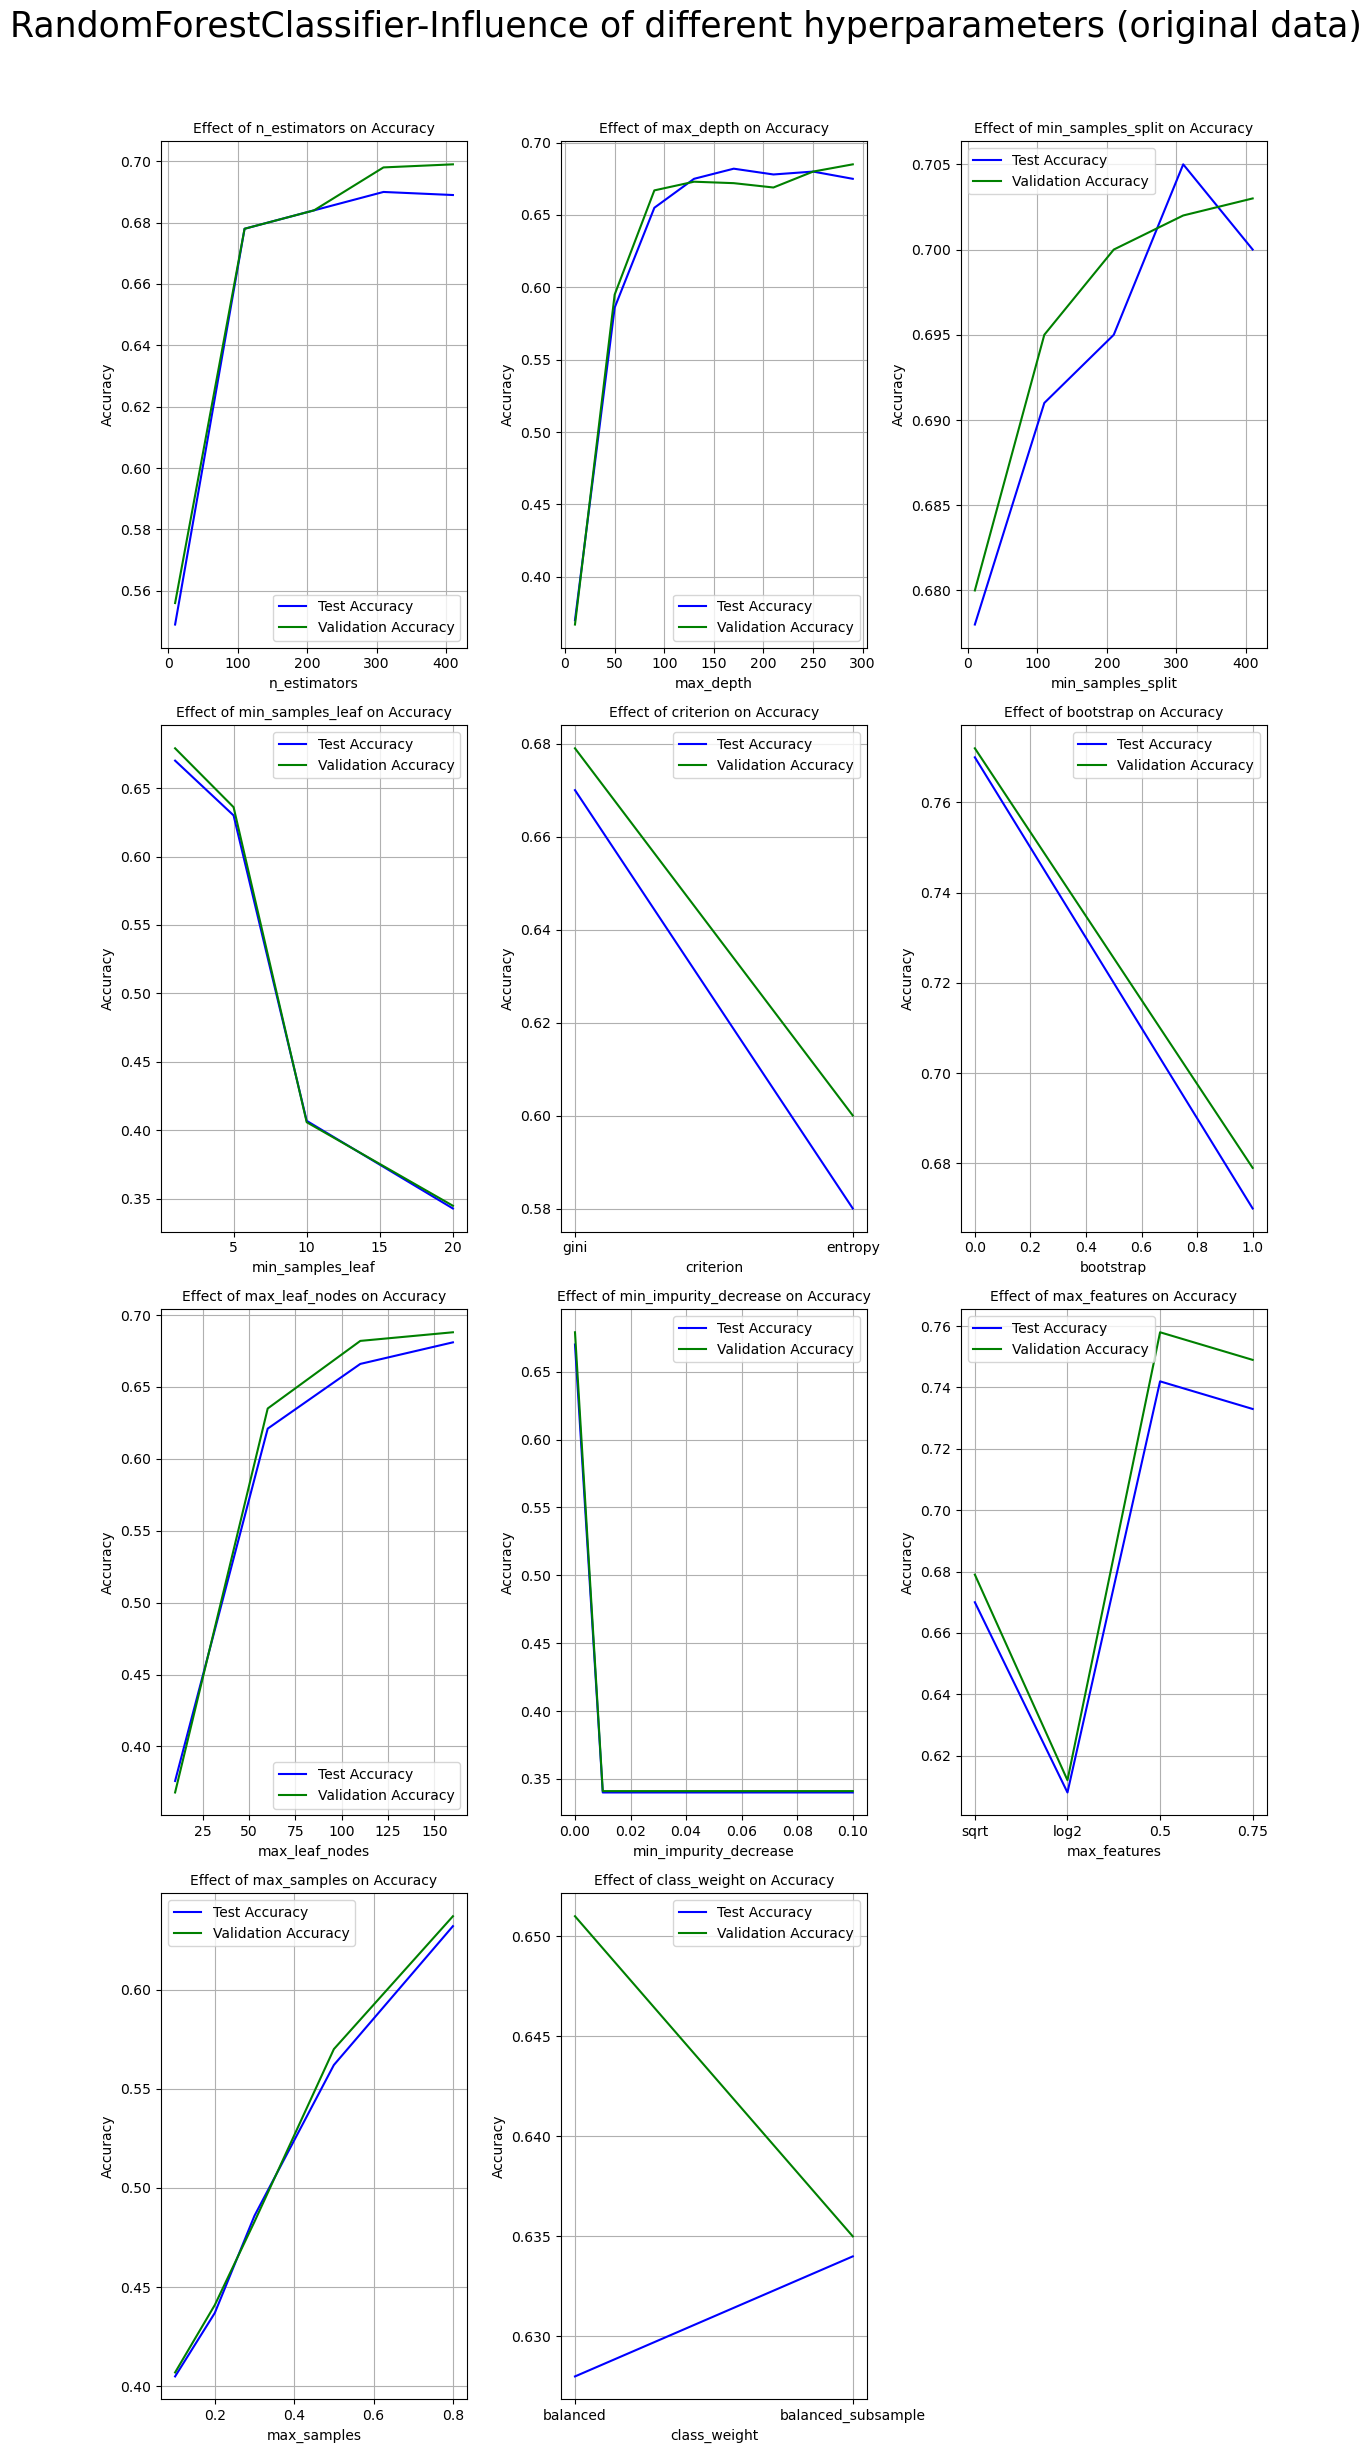

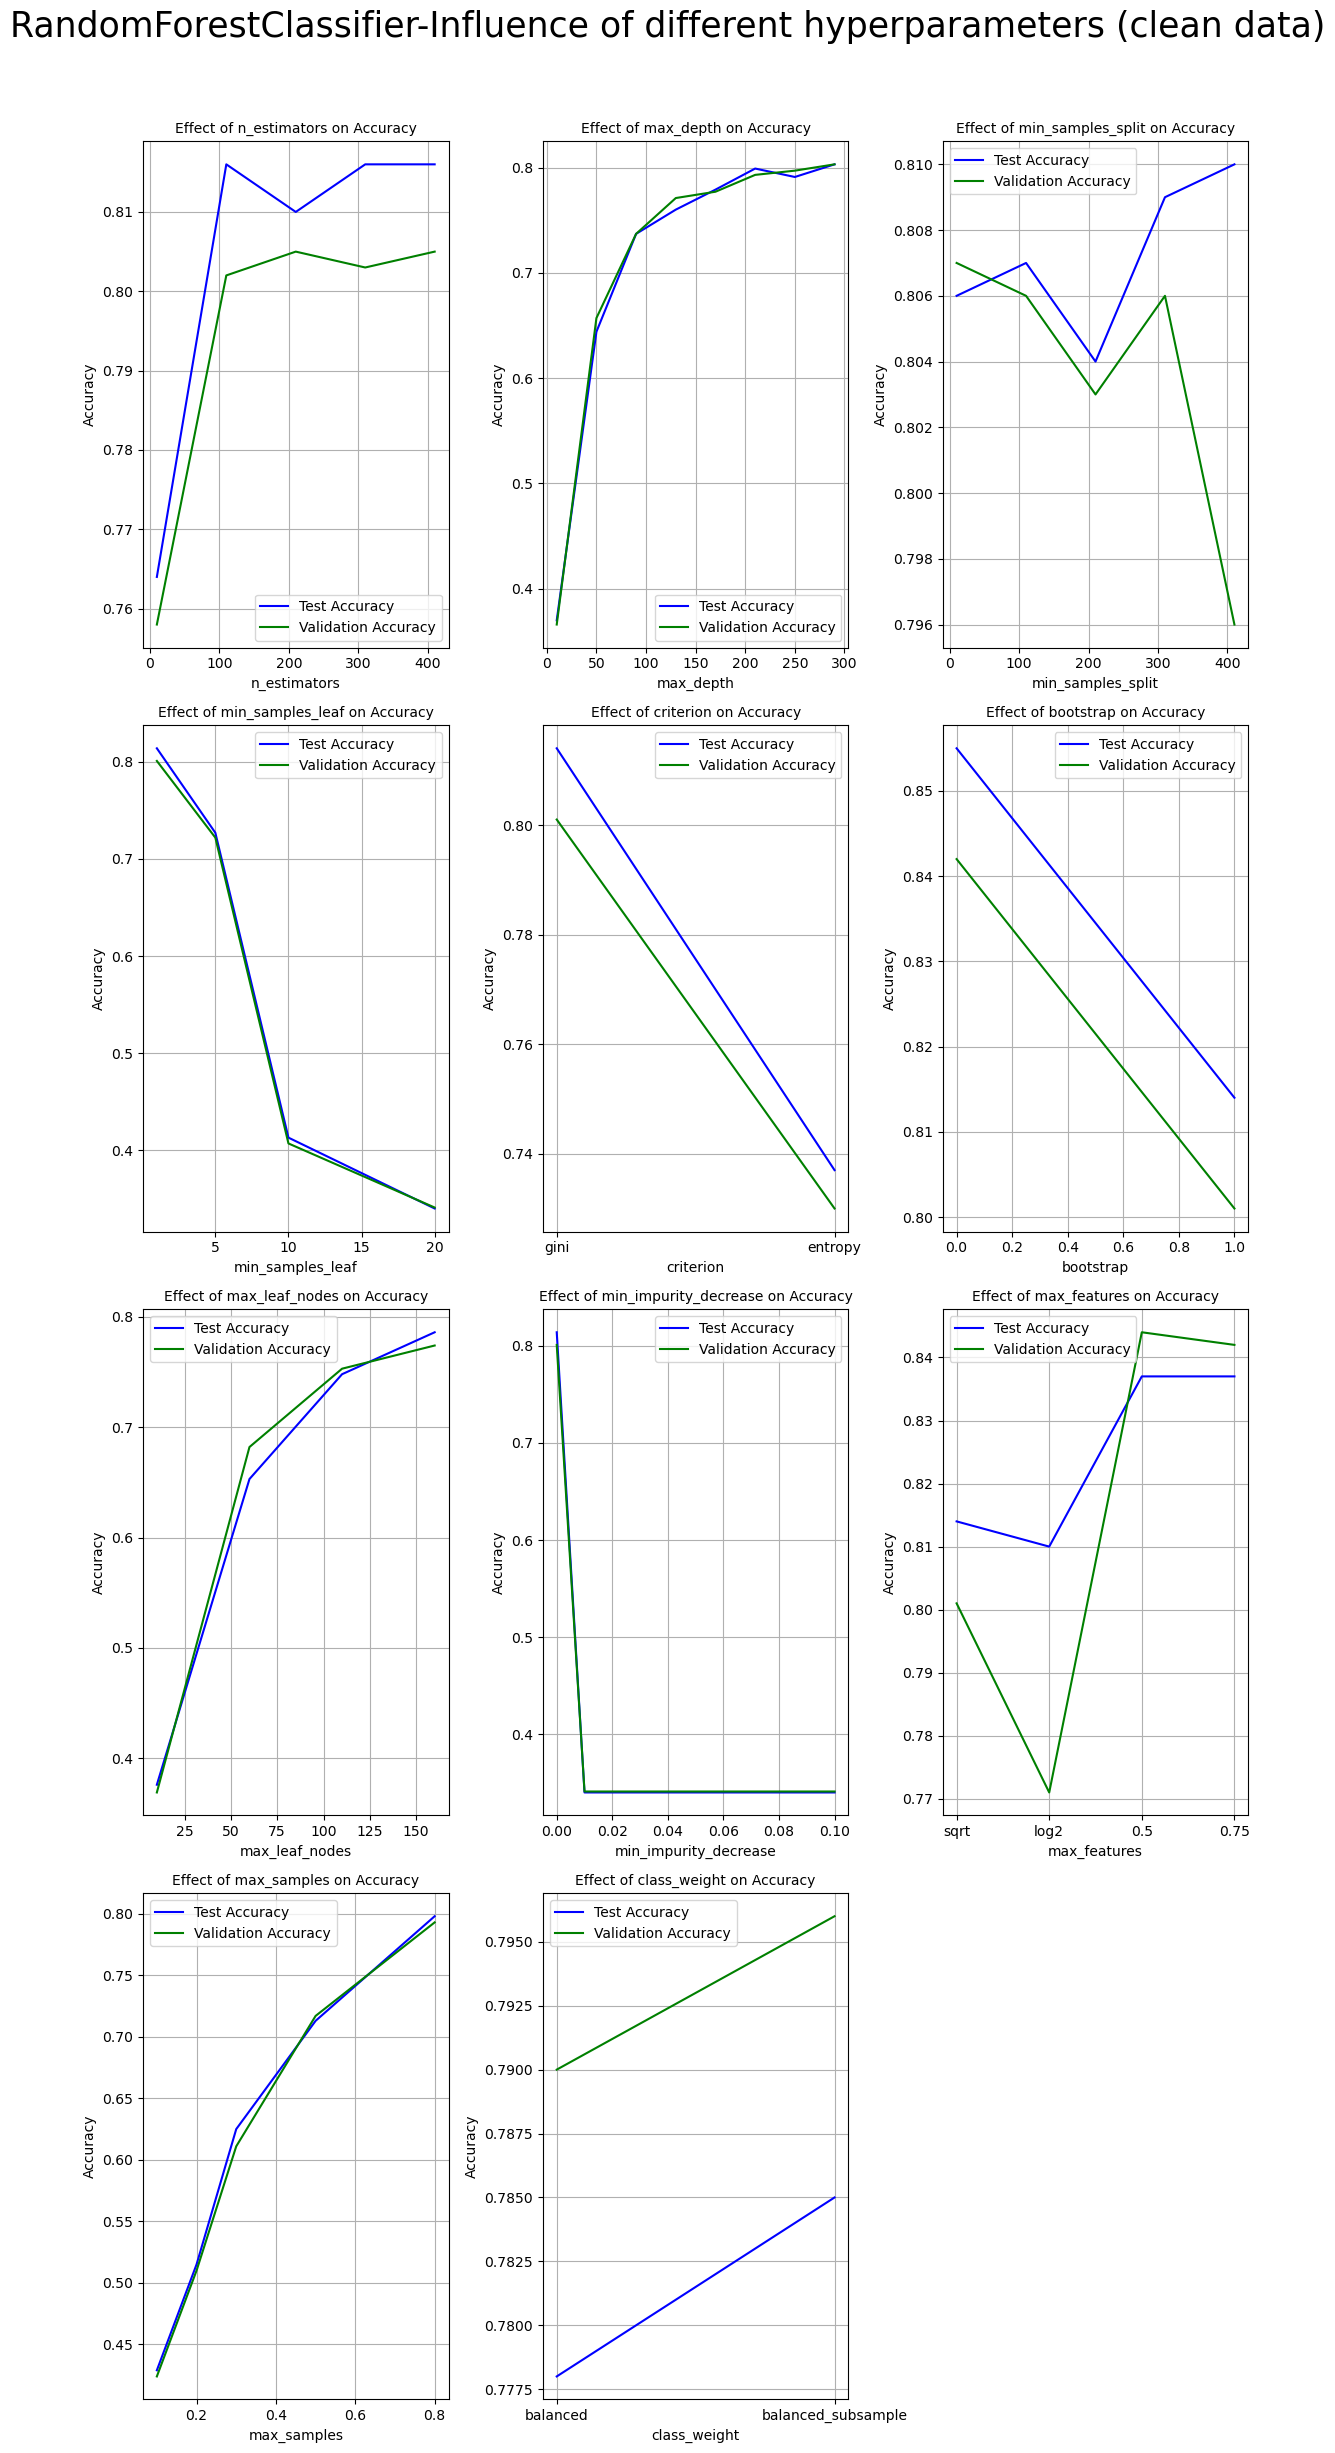

In [81]:
para_names_RF = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "criterion", "bootstrap", "max_leaf_nodes", "min_impurity_decrease", "max_features", "max_samples", "class_weight"]
para_values_RF = [np.arange(10,500,100), np.arange(10, 300, 40), np.arange(10,500,100), [1, 5, 10,20], ['gini', 'entropy'], [True, False], np.arange(10,200,50), [0.0, 0.01, 0.05, 0.1], ['sqrt', 'log2', 0.5, 0.75], [0.1, 0.2, 0.3, 0.5, 0.8], ['balanced', 'balanced_subsample']]
plt_parameters("RandomForestClassifier", pipeline, para_names_RF, para_values_RF, datasets["unclean"]["X_train"], datasets["unclean"]["y_train"], datasets["unclean"]["X_val"], datasets["unclean"]["y_val"], datasets["unclean"]["y_test"], datasets["unclean"]["X_test"],data_name="original data")
plt_parameters("RandomForestClassifier", pipeline, para_names_RF, para_values_RF, datasets["clean"]["X_train"], datasets["clean"]["y_train"], datasets["clean"]["X_val"], datasets["clean"]["y_val"], datasets["clean"]["y_test"], datasets["clean"]["X_test"],data_name="clean data")

In [99]:
def objective_Forest(trial, X_train, y_train):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)

    pipeline.set_params(
        classifier__n_estimators=n_estimators,
        classifier__max_depth=max_depth,
        classifier__min_samples_split=min_samples_split,
        classifier__min_samples_leaf=min_samples_leaf,
        classifier__criterion=criterion,
        classifier__bootstrap=bootstrap,
        classifier__max_leaf_nodes=max_leaf_nodes
    )

    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy')
    return score.mean()


def optimize_and_evaluate(dataset_name):
    print(f"\nOptimizing for {dataset_name} dataset...")
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective_Forest(
            trial,
            datasets[dataset_name]["X_train"],
            datasets[dataset_name]["y_train"]
        ),
        n_trials=100
    )

    best_trial = study.best_trial
    print(f"\nBest Parameters ({dataset_name.capitalize()} Data): {best_trial.params}")
    print(f"Best Score: {best_trial.value}")

  
    best_params = best_trial.params

    best_model = pipeline.set_params(
        classifier__n_estimators=best_params['n_estimators'],
        classifier__max_depth=best_params['max_depth'],
        classifier__min_samples_split=best_params['min_samples_split'],
        classifier__min_samples_leaf=best_params['min_samples_leaf'],
        classifier__criterion=best_params['criterion'],
        classifier__bootstrap=best_params['bootstrap'],
        classifier__max_leaf_nodes=best_params['max_leaf_nodes']
    )


    best_model.fit(datasets[dataset_name]["X_train"], datasets[dataset_name]["y_train"])

    test_accuracy = accuracy_score(
        datasets[dataset_name]["y_test"],
        best_model.predict(datasets[dataset_name]["X_test"])
    )
    print(f"\nTest Accuracy with the Best Model ({dataset_name.capitalize()} Data): {test_accuracy:.2f}")

    return best_trial, test_accuracy

results_unclean = optimize_and_evaluate("unclean")
results_clean = optimize_and_evaluate("clean")

print("\nComparison of Results:")
print(f"Unclean Dataset - Best Parameters: {results_unclean[0].params}, Test Accuracy: {results_unclean[1]:.2f}")
print(f"Clean Dataset   - Best Parameters: {results_clean[0].params}, Test Accuracy: {results_clean[1]:.2f}")


[I 2025-01-11 14:58:19,901] A new study created in memory with name: no-name-12bac99c-3f94-45a9-9bd9-a2da99c25652



Optimizing for unclean dataset...


[I 2025-01-11 14:58:20,808] Trial 0 finished with value: 0.364 and parameters: {'n_estimators': 167, 'max_depth': 89, 'min_samples_split': 46, 'min_samples_leaf': 18, 'criterion': 'gini', 'bootstrap': False, 'max_leaf_nodes': 86}. Best is trial 0 with value: 0.364.
[I 2025-01-11 14:58:21,852] Trial 1 finished with value: 0.4133333333333333 and parameters: {'n_estimators': 111, 'max_depth': 44, 'min_samples_split': 14, 'min_samples_leaf': 12, 'criterion': 'entropy', 'bootstrap': False, 'max_leaf_nodes': 51}. Best is trial 1 with value: 0.4133333333333333.
[I 2025-01-11 14:58:23,162] Trial 2 finished with value: 0.363 and parameters: {'n_estimators': 199, 'max_depth': 69, 'min_samples_split': 28, 'min_samples_leaf': 18, 'criterion': 'gini', 'bootstrap': False, 'max_leaf_nodes': 49}. Best is trial 1 with value: 0.4133333333333333.
[I 2025-01-11 14:58:24,046] Trial 3 finished with value: 0.389 and parameters: {'n_estimators': 149, 'max_depth': 79, 'min_samples_split': 16, 'min_samples_leaf


Best Parameters (Unclean Data): {'n_estimators': 158, 'max_depth': 94, 'min_samples_split': 50, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'max_leaf_nodes': 96}
Best Score: 0.7196666666666667


[I 2025-01-11 15:02:46,363] A new study created in memory with name: no-name-3d3d1341-07ef-4a39-aa0c-2c4047c2cf08



Test Accuracy with the Best Model (Unclean Data): 0.73

Optimizing for clean dataset...


[I 2025-01-11 15:02:48,262] Trial 0 finished with value: 0.6859999999999999 and parameters: {'n_estimators': 141, 'max_depth': 86, 'min_samples_split': 4, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': True, 'max_leaf_nodes': 72}. Best is trial 0 with value: 0.6859999999999999.
[I 2025-01-11 15:02:49,310] Trial 1 finished with value: 0.367 and parameters: {'n_estimators': 187, 'max_depth': 45, 'min_samples_split': 34, 'min_samples_leaf': 16, 'criterion': 'entropy', 'bootstrap': False, 'max_leaf_nodes': 58}. Best is trial 0 with value: 0.6859999999999999.
[I 2025-01-11 15:02:50,275] Trial 2 finished with value: 0.34066666666666673 and parameters: {'n_estimators': 193, 'max_depth': 94, 'min_samples_split': 45, 'min_samples_leaf': 20, 'criterion': 'entropy', 'bootstrap': True, 'max_leaf_nodes': 43}. Best is trial 0 with value: 0.6859999999999999.
[I 2025-01-11 15:02:51,257] Trial 3 finished with value: 0.369 and parameters: {'n_estimators': 168, 'max_depth': 27, 'min_samples_spl


Best Parameters (Clean Data): {'n_estimators': 177, 'max_depth': 95, 'min_samples_split': 11, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': False, 'max_leaf_nodes': 100}
Best Score: 0.7476666666666667

Test Accuracy with the Best Model (Clean Data): 0.76

Comparison of Results:
Unclean Dataset - Best Parameters: {'n_estimators': 158, 'max_depth': 94, 'min_samples_split': 50, 'min_samples_leaf': 3, 'criterion': 'gini', 'bootstrap': False, 'max_leaf_nodes': 96}, Test Accuracy: 0.73
Clean Dataset   - Best Parameters: {'n_estimators': 177, 'max_depth': 95, 'min_samples_split': 11, 'min_samples_leaf': 4, 'criterion': 'gini', 'bootstrap': False, 'max_leaf_nodes': 100}, Test Accuracy: 0.76


### SVC - Support Vector Classification

In [82]:
classifier = SVC(random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC(random_state=42))
    
])



ORIGINAL DATA
Validation Accuracy: 0.61
Test Accuracy: 0.63

 CLEAN DATA
Validation Accuracy: 0.67
Test Accuracy: 0.69


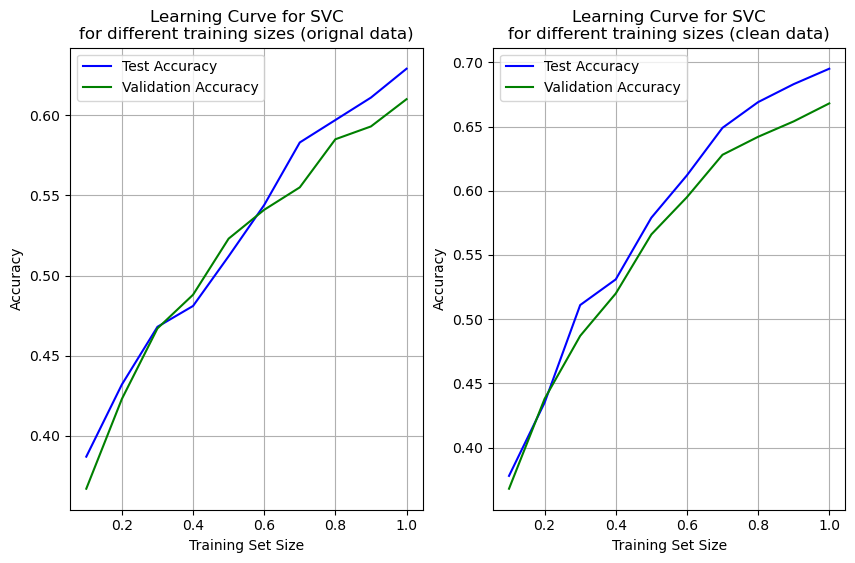

In [83]:
print("\nORIGINAL DATA")
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
pipeline, results_unclean = plot_learning_curve(
    classifier, 
    datasets["unclean"]["X_train"], 
    datasets["unclean"]["y_train"], 
    datasets["unclean"]["X_val"], 
    datasets["unclean"]["y_val"], 
    datasets["unclean"]["X_test"], 
    datasets["unclean"]["y_test"],
    name_unclean
)
print("\n CLEAN DATA")
plt.subplot(1, 2, 2)
pipeline, results_clean = plot_learning_curve(
    classifier, 
    datasets["clean"]["X_train"], 
    datasets["clean"]["y_train"], 
    datasets["clean"]["X_val"], 
    datasets["clean"]["y_val"], 
    datasets["clean"]["X_test"], 
    datasets["clean"]["y_test"],
    name_clean
)


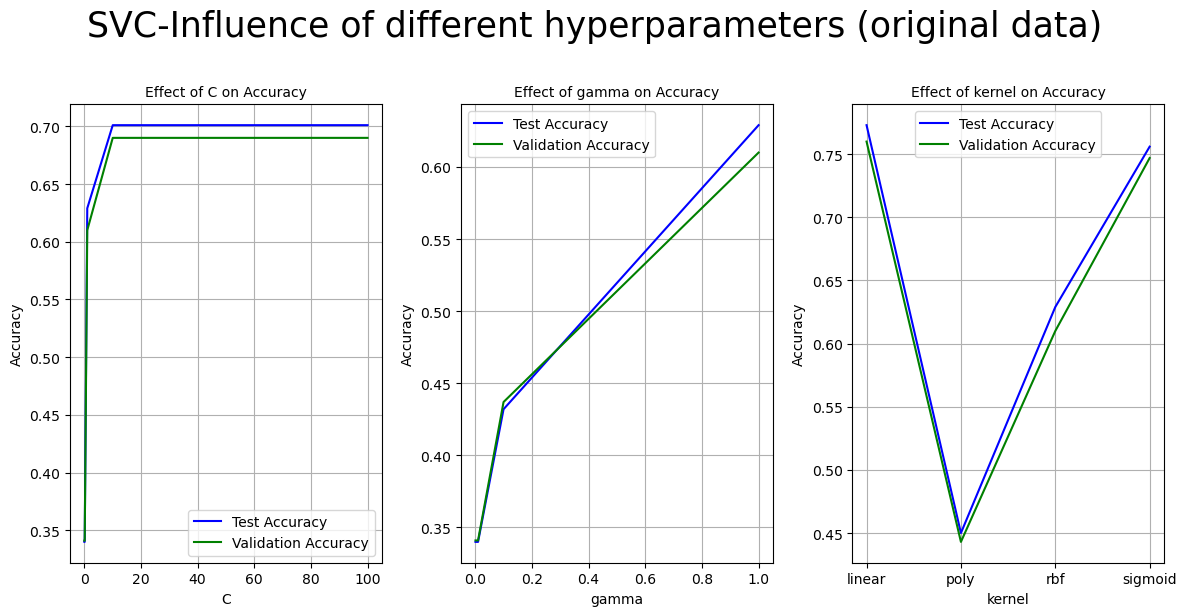

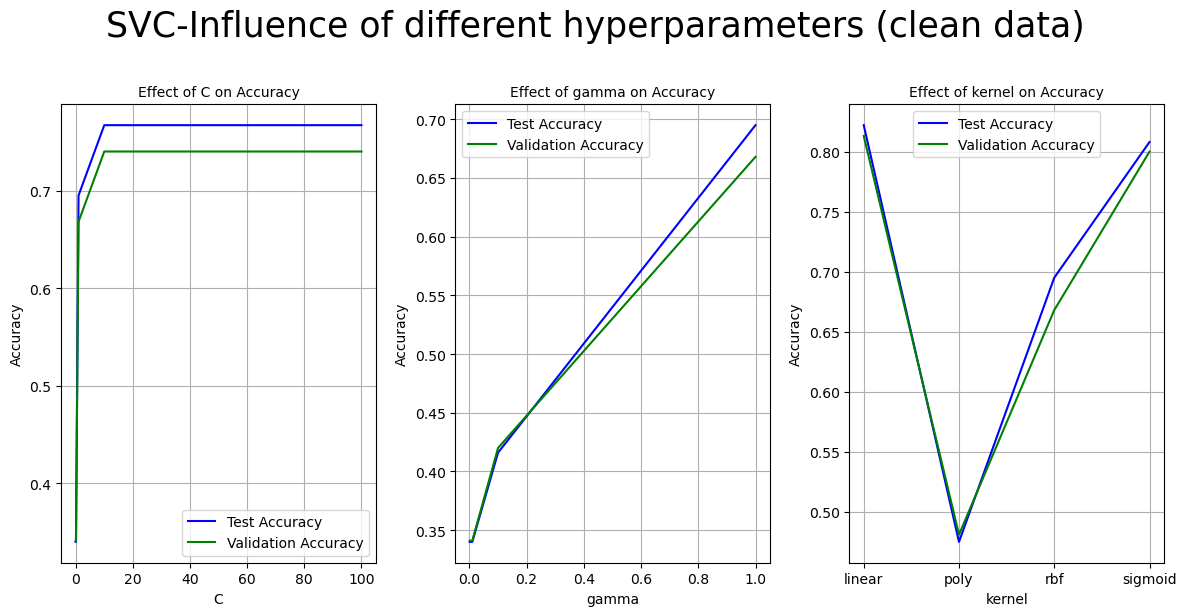

In [101]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC())
])

para_names_SVC = ["C", "gamma",   "kernel"]
para_values_SVC = [np.logspace(-3, 2, 6),[0.001, 0.01, 0.1, 1],  ['linear', 'poly', 'rbf', 'sigmoid']]
plt_parameters("SVC", pipeline, para_names_SVC, para_values_SVC, datasets["unclean"]["X_train"], datasets["unclean"]["y_train"], datasets["unclean"]["X_val"], datasets["unclean"]["y_val"], datasets["unclean"]["y_test"], datasets["unclean"]["X_test"],data_name="original data")
plt_parameters("SVC", pipeline, para_names_SVC, para_values_SVC, datasets["clean"]["X_train"], datasets["clean"]["y_train"], datasets["clean"]["X_val"], datasets["clean"]["y_val"], datasets["clean"]["y_test"], datasets["clean"]["X_test"],data_name="clean data")

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC())
])



In [104]:
def objective_SVC(trial, X_train, y_train):
    # Define the hyperparameter search space for SVC
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)  # Use suggest_float with log=True
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else None

    # Set the pipeline parameters
    pipeline.set_params(
        classifier__C=C,
        classifier__kernel=kernel,
        classifier__gamma=gamma,
        classifier__degree=degree if kernel == 'poly' else 3  # Default to 3 for other kernels
    )

    # Evaluate the pipeline using cross-validation
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy')
    return score.mean()


def optimize_and_evaluate_SVC(dataset_name):
    print(f"\nOptimizing for {dataset_name} dataset...")
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective_SVC(
            trial,
            datasets[dataset_name]["X_train"],
            datasets[dataset_name]["y_train"]
        ),
        n_trials=100
    )

    best_trial = study.best_trial
    print(f"\nBest Parameters ({dataset_name.capitalize()} Data): {best_trial.params}")
    print(f"Best Score: {best_trial.value}")

    # Set the best parameters to the pipeline
    best_params = best_trial.params

    best_model = pipeline.set_params(
        classifier__C=best_params['C'],
        classifier__kernel=best_params['kernel'],
        classifier__gamma=best_params['gamma'],
        classifier__degree=best_params['degree'] if 'degree' in best_params else 3
    )

    # Train the pipeline with the best parameters
    best_model.fit(datasets[dataset_name]["X_train"], datasets[dataset_name]["y_train"])

    # Evaluate the pipeline on the test data
    test_accuracy = accuracy_score(
        datasets[dataset_name]["y_test"],
        best_model.predict(datasets[dataset_name]["X_test"])
    )
    print(f"\nTest Accuracy with the Best Model ({dataset_name.capitalize()} Data): {test_accuracy:.2f}")

    return best_trial, test_accuracy


# Run optimization and evaluation for both unclean and clean datasets
results_unclean_SVC = optimize_and_evaluate_SVC("unclean")
results_clean_SVC = optimize_and_evaluate_SVC("clean")

# Print results for comparison
print("\nComparison of Results:")
print(f"Unclean Dataset - Best Parameters: {results_unclean_SVC[0].params}, Test Accuracy: {results_unclean_SVC[1]:.2f}")
print(f"Clean Dataset   - Best Parameters: {results_clean_SVC[0].params}, Test Accuracy: {results_clean_SVC[1]:.2f}")


[I 2025-01-11 15:20:36,624] A new study created in memory with name: no-name-54c25361-1466-4082-9975-8de7c9db7aa5



Optimizing for unclean dataset...


[I 2025-01-11 15:20:47,005] Trial 0 finished with value: 0.34066666666666673 and parameters: {'C': 4.819260702660075, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.34066666666666673.
[I 2025-01-11 15:20:54,610] Trial 1 finished with value: 0.34066666666666673 and parameters: {'C': 0.9334940126851081, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.34066666666666673.
[I 2025-01-11 15:20:57,888] Trial 2 finished with value: 0.34066666666666673 and parameters: {'C': 150.70708757748517, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 0 with value: 0.34066666666666673.
[I 2025-01-11 15:21:01,071] Trial 3 finished with value: 0.34066666666666673 and parameters: {'C': 251.97525922817206, 'kernel': 'poly', 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.34066666666666673.
[I 2025-01-11 15:21:06,607] Trial 4 finished with value: 0.6653333333333334 and parameters: {'C': 276.4240266385594, 'kernel': 'rbf', 'gamma': 'scale'}. 


Best Parameters (Unclean Data): {'C': 2.3840098153708866, 'kernel': 'linear', 'gamma': 'scale'}
Best Score: 0.77


[I 2025-01-11 15:28:42,628] A new study created in memory with name: no-name-40a0cda1-9694-497c-96d0-0ca0e04a1690



Test Accuracy with the Best Model (Unclean Data): 0.80

Optimizing for clean dataset...


[I 2025-01-11 15:28:46,109] Trial 0 finished with value: 0.7120000000000001 and parameters: {'C': 17.25615095962517, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.7120000000000001.
[I 2025-01-11 15:28:48,236] Trial 1 finished with value: 0.34066666666666673 and parameters: {'C': 0.00119623949929304, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.7120000000000001.
[I 2025-01-11 15:28:50,138] Trial 2 finished with value: 0.34066666666666673 and parameters: {'C': 6.6392161453579694, 'kernel': 'poly', 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.7120000000000001.
[I 2025-01-11 15:28:52,102] Trial 3 finished with value: 0.34066666666666673 and parameters: {'C': 0.0013276974914290106, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 0 with value: 0.7120000000000001.
[I 2025-01-11 15:28:54,442] Trial 4 finished with value: 0.34066666666666673 and parameters: {'C': 0.28166920933658085, 'kernel': 'rbf', 'gamma': 'auto'}. Be


Best Parameters (Clean Data): {'C': 1.615605332887113, 'kernel': 'linear', 'gamma': 'auto'}
Best Score: 0.8076666666666666

Test Accuracy with the Best Model (Clean Data): 0.83

Comparison of Results:
Unclean Dataset - Best Parameters: {'C': 2.3840098153708866, 'kernel': 'linear', 'gamma': 'scale'}, Test Accuracy: 0.80
Clean Dataset   - Best Parameters: {'C': 1.615605332887113, 'kernel': 'linear', 'gamma': 'auto'}, Test Accuracy: 0.83
